**##############  Tools Setup  ##############**

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# Importing the Keras libraries and packages
import kerastuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

**##############  Import datasets  ##############**

In [21]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

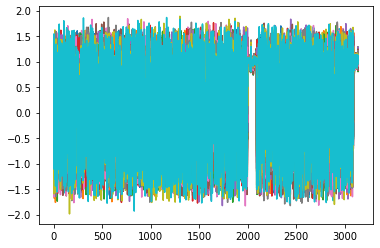

In [23]:
plt.show(plt.plot(test))

In [3]:
def get_means_1(df):
    df_means = df.mean(axis = 1)
    for i in range(len(df_means)):
        if df_means[i] < 0.8:
            df = df.drop([i])
    return df

def get_means_0(df):
    df_means = df.mean(axis = 1)
    for i in range(len(df_means)):
        if df_means[i] >0.1:
            df = df.drop([i])
    return df

In [4]:
test1 = get_means_0(test)
test2 = get_means_1(test)

In [5]:
train1 = train.iloc[:7000]
train2 = train.iloc[7000:]

**##############  Preprocessing  ##############**

In [6]:
targets1 = train1['y']
targets2 = train2['y']
targets = train['y']
train = train.drop(columns = ['y', 'w'])
train1 = train1.drop(columns=['y','w'])
train2 = train2.drop(columns=['y','w'])

**Data Scaling**(optional, better accuracy without)

In [7]:
# define min max scaler
scaler = MinMaxScaler(feature_range = (-1.94,1.93))
# transform data
def scale_selected_rows(df, start, end):
    df1 = df.copy()
    end = end+1
    df1.loc[start:end] = scaler.fit_transform(df1.loc[start:end])
    return df1

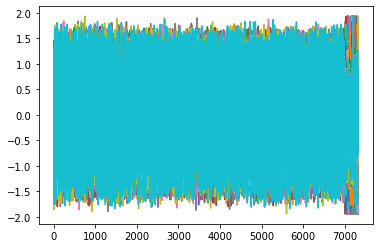

In [8]:
train_scaled = scale_selected_rows(train,7000,7325)

plt.show(plt.plot(train_scaled))

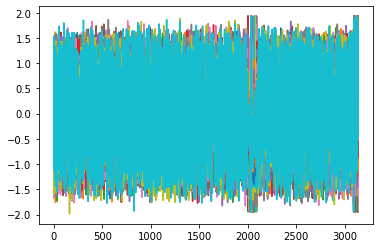

In [9]:
test_scaled_half = scale_selected_rows(test,2000,2091)
test_scaled = scale_selected_rows(test_scaled_half,3093,3140)
plt.show(plt.plot(test_scaled))

In [10]:
targets = pd.DataFrame(targets.to_numpy().reshape(7326,1))

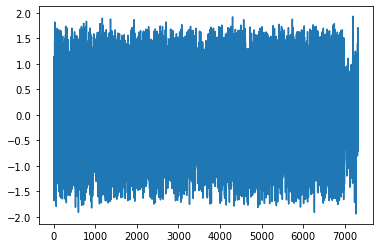

In [11]:
targets_scaled = scale_selected_rows(targets,7000,7325)

plt.show(plt.plot(targets_scaled))

In [12]:
train = train_scaled
test = test_scaled
targets = targets_scaled

**##############  Auto-Tune (does not work)  ##############**

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(train, targets, test_size=0.2,train_size=0.8)

In [14]:
X = train.values.reshape(7326,50,1)
y = targets.values.reshape(7326,1,1)
test = test.values.reshape(3141,50,1)

In [15]:
X_tr = X_tr.values.reshape(5860,50,1)
y_tr = y_tr.values.reshape(5860,1,1)
X_te = X_te.values.reshape(1466,50,1)
y_te = y_te.values.reshape(1466,1,1)

X_tr_sh, y_tr_sh = shuffle(X_tr, y_tr)
X_te_sh, y_te_sh = shuffle(X_te, y_te)

In [16]:
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units',
                                        min_value=20,
                                        max_value=40,
                                        step=3),
                           return_sequences = True, input_shape = (X_tr.shape[1], 1)))
    model.add(Dropout(0.25))
    
    model.add(LSTM(units=hp.Int('units',
                                        min_value=20,
                                        max_value=40,
                                        step=3),
                           return_sequences = True))
    model.add(Dropout(0.25))
    
    model.add(LSTM(units=hp.Int('units',
                                        min_value=20,
                                        max_value=40,
                                        step=3),
                           ))
    model.add(Dropout(0.25))

    model.add(Dense(units = 1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-1, 1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [18]:
tuner = kt.Hyperband(
    build_model,
    objective='val_mean_squared_error',
    max_epochs=100,
    hyperband_iterations=2,
    directory='Megaus')

In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 40, 'step': 2, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
tuner.search(X_tr_sh,y_tr_sh,
             epochs=5,
             validation_data=(X_te_sh,y_te_sh))

Trial 10 Complete [00h 00m 23s]
val_mean_squared_error: 0.09676369279623032

Best val_mean_squared_error So Far: 0.029269695281982422
Total elapsed time: 00h 03m 38s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
units             |32                |40                
learning_rate     |0.1               |0.01              
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |3                 |3                 
tuner/round       |0                 |0                 

Epoch 1/2
184/184 [==============================] - 15s 59ms/step - loss: 1.2778 - mean_squared_error: 1.2778 - val_loss: 0.2085 - val_mean_squared_error: 0.2085
Epoch 2/2
 50/184 [=======>......................] - ETA: 7s - loss: 0.2397 - mean_squared_error: 0.2397 ETA: 8s - loss: 0.252

KeyboardInterrupt: 

**##############  Build Regressor  ##############**

In [11]:
best = tuner.get_best_models(num_models=1)[0]

**##############  Fit Regressor  ##############**

In [14]:
best.fit(X, y, epochs = 50, batch_size = 16)

Epoch 1/50
458/458 [==============================] - 16s 35ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 2/50
458/458 [==============================] - 15s 32ms/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 3/50
458/458 [==============================] - 15s 33ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 4/50
426/458 [==========================>...] - ETA: 1s - loss: 0.0315 - mean_squared_error: 0.0315

KeyboardInterrupt: 

**##############  Test Predictions  ##############**

In [21]:
y_pred = best.predict(test)

**##############  Save File  ##############**

In [22]:
np.savetxt('RNNautotuned.txt', np.c_[y_pred])